# Análise e Identificação de SPAM em SMS

**Curso:** Ciência de Dados para Négócios

**Turma:** 3º semestre

**Integrantes do Projeto:** Donizete Gomes, Mariana Curvelo, Natalia Toledo, Pedro Valadares

`URL do Dataset:` 'https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip'

`OBJETIVO:` construir um modelo que consiga diferenciar uma mensagem de SMS normal ("ham") de uma mensagem de spam ("spam").

## **1. Carregamento e Exploração Inicial**

*   Importar o dataset (disponível no link do UCI).;
*   Analisar a distribuição das classes (ham vs. spam);
*   Verificar exemplos de mensagens de cada classe.

In [1]:
# Descomente a dependência caso ainda não esteja instalado
# %pip install -q imblearn

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import chardet
import random
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import string
import unicodedata
import nltk
import re
import time
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report


from sklearn.svm import LinearSVC                       # SVM Linear
from sklearn.naive_bayes import MultinomialNB           # Naive Bayes Multinomial
from sklearn.linear_model import LogisticRegression     # Regressão Logística
from sklearn.ensemble import RandomForestClassifier     # Random Forest

import imblearn
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
# Carregamento do arquivo
arquivo = 'SMSSpamCollection'


def encoding_load_data(arquivo):

  # Valores que serão considerados como ausentes
  labels_valores_ausente = ["n/a", "na", "NaN", "nan", "",
                            " ", "NULL", "null", None, np.nan]

  # Detectar a codificação do arquivo
  with open(arquivo, 'rb') as dado_cru:

      encoding_result = chardet.detect(dado_cru.read(100000))

  df = pd.read_csv(
      arquivo,
      sep = '\t',
      names = ['target', 'mensagem'],
      header = None,
      encoding = encoding_result['encoding'])
  print(f"Aplicando o encoding '{encoding_result['encoding']}' ao dataset `{arquivo}`.\n")

  return df

df = encoding_load_data(arquivo)
df

Aplicando o encoding 'utf-8' ao dataset `SMSSpamCollection`.



,target,mensagem
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
# Checar informações e distribuição
print("Infos".center(50, '-'))
print(f'{df.info()}\n')

print('Frequência das classes da variável alvo'.center(50, '-'))
df['target'].value_counts()


----------------------Infos-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   target    5572 non-null   object
 1   mensagem  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

-----Frequência das classes da variável alvo------


,count
target,
ham,4825
spam,747


## **2. Pré-processamento de Texto**

*   Limpar o texto: remover caracteres especiais, números e converter para minúsculas.
*   Tokenizar as mensagens (dividir em palavras ou termos).

In [5]:
df1 = df.copy()

In [6]:
df1.isnull().sum()

,0
target,0
mensagem,0


In [7]:
def limpar_texto_eng(texto):

  # Converter para minúsculas
  texto = texto.lower()

  # Normalizar e remover acentos
  texto = unicodedata.normalize('NFKD', texto).encode('ascii', 'ignore').decode('utf-8')

  # Remover pontuações e números
  txt_sem_pontuacao_numeros = re.sub(r'[^a-z\s]', '', texto)

  # Remover 'stop words' em inglês
  palavras = txt_sem_pontuacao_numeros.split()
  stopwords_ingles = set(stopwords.words('english'))
  palavras_limpas = [palavra for palavra in palavras if palavra not in stopwords_ingles]

  # Remover tokens muito curtos
  palavras_limpas = [p for p in palavras_limpas if len(p) > 2]

  # Remover múltiplos espaços
  palavras_limpas = ' '.join(palavras_limpas)

  # Ajustar palavras
  lemmatizer = WordNetLemmatizer()
  palavras_limpas = [lemmatizer.lemmatize(p) for p in palavras_limpas]


  # Juntar as palavras em uma única string
  texto_limpo = ''.join(palavras_limpas)
  return texto_limpo

* Aplicar a limpeza da mensagem

In [8]:
df1['texto_limpo'] = df1['mensagem'].apply(limpar_texto_eng)
df1.head()

,target,mensagem,texto_limpo
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis great world...
1,ham,Ok lar... Joking wif u oni...,lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win cup final tkts may te...
3,ham,U dun say so early hor... U c already then say...,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


In [9]:
# Linha 1: Resultado da mensagem original
display(f'Resultado da mensagem original:', df1.loc[0, 'mensagem'])
print('\n')

# Linha 1: Resultado da mensagem ajustada
display(f'Resultado da mensagem ajustada:', df1.loc[0, 'texto_limpo'])

'Resultado da mensagem original:'

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

'Resultado da mensagem ajustada:'

'jurong point crazy available bugis great world buffet cine got amore wat'

* Visualização com Nuvem de Palavras

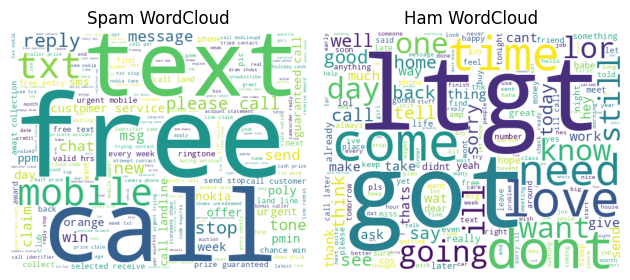

In [10]:
def nuvem_palavras(df, col_target, col_mensagem):

  palavras_spam = ' '.join(df1[df1[col_target] == 'spam'][col_mensagem])
  palavras_ham = ' '.join(df1[df1[col_target] == 'ham'][col_mensagem])

  plt.subplot(1, 2, 1)
  plt.title("Spam WordCloud")
  WordCloud(width = 500, height = 400, background_color = 'white').generate(palavras_spam)
  plt.imshow(WordCloud(width = 500, height = 400, background_color = 'white').generate(palavras_spam))
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.title("Ham WordCloud")
  plt.imshow(WordCloud(width = 500, height = 400, background_color='white').generate(palavras_ham))
  plt.axis('off')

  plt.tight_layout()
  plt.show()

nuvem_palavras(df1, 'target', 'texto_limpo')

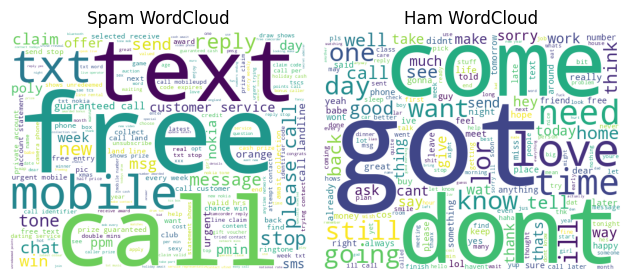

Counter()


In [11]:
# Remoção de residos que provêm do html
padrao = r'\b(?:lt|gt|amp|ltgt)\b'

df1['texto_limpo'] = df1['texto_limpo'].str.replace(padrao, '', regex = True)
nuvem_palavras(df1, 'target', 'texto_limpo')

# Checagem
todos_textos = ' '.join(df1['texto_limpo'])
contagem = Counter(re.findall(padrao, todos_textos))
print(contagem)

In [12]:
# Checagem de valores duplicados
print(f'Quantidade de linhas duplicadas: {df1.duplicated().sum()}\n')
display(df1[df1.duplicated() == True])

# remoção de duplicatas
df1.drop_duplicates(inplace = True)
print(f'\nQuantidade de linhas duplicadas após o tratamento: {df1.duplicated().sum()}\n')

Quantidade de linhas duplicadas: 403



,target,mensagem,texto_limpo
103,ham,As per your request 'Melle Melle (Oru Minnamin...,per request melle melle oru minnaminunginte nu...
154,ham,As per your request 'Melle Melle (Oru Minnamin...,per request melle melle oru minnaminunginte nu...
207,ham,"As I entered my cabin my PA said, '' Happy B'd...",entered cabin said happy bday boss felt specia...
223,ham,"Sorry, I'll call later",sorry ill call later
326,ham,No calls..messages..missed calls,callsmessagesmissed calls
...,...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...,awarded sipix digital camera call landline del...
5535,ham,"I know you are thinkin malaria. But relax, chi...",know thinkin malaria relax children cant handl...
5539,ham,Just sleeping..and surfing,sleepingand surfing
5553,ham,Hahaha..use your brain dear,hahahause brain dear



Quantidade de linhas duplicadas após o tratamento: 0



In [13]:
# Contar a frequência das classes
freq = df1['target'].value_counts().reset_index()
freq.columns = ['target', 'mensagem']

# Selecionar uma cor aleatória para cada fatia do gráfico
# cores_aleatorias = random.sample(cores_disponiveis, k = len(freq))

# Checar informações e distribuição
print("Infos".center(50, '-'))
print(f'{df1.info()}\n')


# Criar o gráfico de donout
fig = go.Figure(data = [go.Pie(
        labels = freq['target'],
        values = freq['mensagem'],
        hole = 0.3,
        # marker_colors = cores_aleatorias
)])

fig.update_layout(
    width = 800,
    height = 500,
    title_text = "Distribuição da classe Spam vs Não Spam",
    title_x = 0.5
)

fig.show()

----------------------Infos-----------------------
<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   target       5169 non-null   object
 1   mensagem     5169 non-null   object
 2   texto_limpo  5169 non-null   object
dtypes: object(3)
memory usage: 161.5+ KB
None



#### Ajuste da variável alvo

In [14]:
df1['target'] = df1['target'].map({'ham' : 0, 'spam' : 1}).astype(int)
df1.head()

,target,mensagem,texto_limpo
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis great world...
1,0,Ok lar... Joking wif u oni...,lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win cup final tkts may te...
3,0,U dun say so early hor... U c already then say...,dun say early hor already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


## **3. Divisão em Treino e Teste**

Data_Leakeage:

* https://ucsc-ospo.github.io/report/osre24/nyu/data-leakage/20240905-kyrillosishak/ (Foco no TF-IDF)
* https://journalofbigdata.springeropen.com/articles/10.1186/s40537-025-01193-8 (Parágrafo 6 em diante)
* https://medium.com/@andreycp17/data-leakage-o-que-%C3%A9-como-evitar-ba1fa8c9db70 (Medium)
* https://www.edwinwenink.xyz/posts/61-feature_preprocessing_and_train_test_leakage/ (Aplicações)


In [15]:
# Removendo a coluna mensagem e deixando apenas a coluna com o texto limpo
df_para_treino_teste = df1.copy()
df_para_treino_teste.drop('mensagem', axis = 1, inplace = True)

# Ajuste da variável dependente e independente
y = df_para_treino_teste.target
X = df_para_treino_teste.drop('target', axis = 1)

# Incluí a verificação da proporção na variável target.
# Quero comparar antes e depois da divisão em treino e teste.
print(" Proporção da variável target original(y) ".center(50,  '-'))
print(df_para_treino_teste['target'].value_counts(normalize = True))

---- Proporção da variável target original(y) ----
target
0    0.87367
1    0.12633
Name: proportion, dtype: float64


Aplicando a divisão em treino e teste com amostragem estratificada

In [16]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X,
                                                        y,
                                                        test_size = 0.3,
                                                        random_state = 42,
                                                        stratify = y)

In [17]:
print(f"Tamanho de X_treino: {len(X_treino)}")
print(f"Tamanho de y_treino: {len(y_treino)}")

Tamanho de X_treino: 3618
Tamanho de y_treino: 3618


In [18]:
print('Proporção da variável alvo após o treinamento - (y_teste)'.center(50,  '-'))
print(y_teste.value_counts(normalize = True))

Proporção da variável alvo após o treinamento - (y_teste)
target
0    0.87363
1    0.12637
Name: proportion, dtype: float64


In [19]:
print('Proporção da variável alvo após o treinamento - (y_treino)'.center(100, '-'))
print(y_treino.value_counts(normalize = True))

---------------------Proporção da variável alvo após o treinamento - (y_treino)---------------------
target
0    0.873687
1    0.126313
Name: proportion, dtype: float64


## **4. Vetorização**

No processo final de cada vetorização, aplicamos o teste do modelo, antes do balanceamento apenas para compararmos o quão perigoso pode ser usar os dados desbalanceados. `Considerar os resultados do Modelo apenas após o Balanceamento!`

* TF-IDF

In [20]:
tfidf_vector = TfidfVectorizer(
    stop_words = 'english',
    ngram_range = (1, 2),
    max_features = 5000
)

# Obter a Série de Strings
X_treino_series = X_treino.iloc[:, 0]
X_teste_series = X_teste.iloc[:, 0]

# Aplicação apenas nos dados de IDF de Treino
X_treino_tfidf = tfidf_vector.fit_transform(X_treino_series)

# Transfomação nos dados de Teste
#Aplicar o vacabulário e o IDF aprendidos no treino
X_teste_tfidf = tfidf_vector.transform(X_teste_series)

print("--- TF-IDF Vetorização Completa ---")
print("Formato dos dados de TREINO (TF-IDF):", X_treino_tfidf.shape)
print("Formato dos dados de TESTE (TF-IDF):", X_teste_tfidf.shape)


# ----------------------------------------------------------------------
# 4. Treinamento do Modelo (Exemplo com Naive Bayes) - Apenas para comparação
# ----------------------------------------------------------------------

modelo_tfidf = MultinomialNB()
modelo_tfidf.fit(X_treino_tfidf, y_treino)

y_pred_tfidf = modelo_tfidf.predict(X_teste_tfidf)

print("\n--- Resultado do Modelo (Vetorização TF-IDF) ---")
print(classification_report(y_teste, y_pred_tfidf, zero_division = 0))

--- TF-IDF Vetorização Completa ---
Formato dos dados de TREINO (TF-IDF): (3618, 5000)
Formato dos dados de TESTE (TF-IDF): (1551, 5000)

--- Resultado do Modelo (Vetorização TF-IDF) ---
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1355
           1       1.00      0.69      0.82       196

    accuracy                           0.96      1551
   macro avg       0.98      0.84      0.90      1551
weighted avg       0.96      0.96      0.96      1551



* Bow (Bag of Words)

In [21]:
# ----------------------------------------------------------------------
# 1. Instanciar o Vectorizer (mesmos hiperparâmetros para comparação justa)
# ----------------------------------------------------------------------
bow_vectorizer = CountVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    max_features = 5000
)

# ----------------------------------------------------------------------
# 2. Fit & Transform nos Dados de TREINO
# Lembre-se de usar a Série de Strings correta (ex: X_treino_series, se for o caso)
# ----------------------------------------------------------------------
X_treino_bow = bow_vectorizer.fit_transform(X_treino_series)
X_teste_bow = bow_vectorizer.transform(X_teste_series)

# ----------------------------------------------------------------------
# 3. Treinamento e Avaliação (BoW) - Apenas para comparação
# ----------------------------------------------------------------------
modelo_bow = MultinomialNB()
modelo_bow.fit(X_treino_bow, y_treino)

y_pred_bow = modelo_bow.predict(X_teste_bow)

print("\n--- Resultado do Modelo (Vetorização Bag of Words) ---")
print(classification_report(y_teste, y_pred_bow, zero_division=0))


--- Resultado do Modelo (Vetorização Bag of Words) ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1355
           1       0.94      0.84      0.89       196

    accuracy                           0.97      1551
   macro avg       0.96      0.92      0.94      1551
weighted avg       0.97      0.97      0.97      1551



## **5. Balanceamento de Classe**

In [22]:
###################################################################
######## 1. Aplica SMOTE APENAS no treino vetorizado ##############
###################################################################
smote = SMOTE(sampling_strategy = 'minority', random_state=42)


###################################################################
######## 2. Aplicar SMOTE APENAS nos dados de TREINO ##############
###################################################################

print("Iniciando a geração de dados sintéticos com SMOTE (apenas no TREINO)...\n")
start_time_smote = time.time()

# Embora ele tenha suporte para esparsas, podemos forçar a conversão:
X_treino_sm, y_treino_sm = smote.fit_resample(X_treino_bow, y_treino)

end_time_smote = time.time()
print(f"SMOTE concluído em {end_time_smote - start_time_smote:.2f} segundos.")
print(f"Contagem de classes antes do SMOTE (y_treino): {y_treino.value_counts()}")
print(f"Contagem de classes DEPOIS do SMOTE (y_treino_sm): {y_treino_sm.value_counts()}")

Iniciando a geração de dados sintéticos com SMOTE (apenas no TREINO)...

SMOTE concluído em 0.03 segundos.
Contagem de classes antes do SMOTE (y_treino): target
0    3161
1     457
Name: count, dtype: int64
Contagem de classes DEPOIS do SMOTE (y_treino_sm): target
0    3161
1    3161
Name: count, dtype: int64


## **6. Treinamento do Modelo**

SVM Linear (Suporte a Máquinas Vetoriais)

In [23]:
print("\n=== Teste 1: SVM Linear (LinearSVC) ===\n")
start_time = time.time()
modelo_svc = LinearSVC(random_state = 42, dual = False)
modelo_svc.fit(X_treino_sm, y_treino_sm)
end_time = time.time()

y_pred_svc = modelo_svc.predict(X_teste_bow)

print(f"Treinamento e Predição concluídos em {end_time - start_time:.2f} segundos.")
print(classification_report(y_teste, y_pred_svc, zero_division = 0))


=== Teste 1: SVM Linear (LinearSVC) ===

Treinamento e Predição concluídos em 0.22 segundos.
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      1355
           1       0.46      0.81      0.58       196

    accuracy                           0.85      1551
   macro avg       0.71      0.83      0.75      1551
weighted avg       0.90      0.85      0.87      1551



Naive Bayes Multinomial

In [24]:
print("\n=== Teste 2: Naive Bayes Multinomial (MNB) ===\n")
start_time = time.time()
# O alpha é um parâmetro de suavização (smoothing) que evita probabilidade zero
modelo_mnb = MultinomialNB(alpha=1.0)
modelo_mnb.fit(X_treino_sm, y_treino_sm)
end_time = time.time()

y_pred_mnb = modelo_mnb.predict(X_teste_bow)

print(f"Treinamento e Predição concluídos em {end_time - start_time:.2f} segundos.")
print(classification_report(y_teste, y_pred_mnb, zero_division=0))


=== Teste 2: Naive Bayes Multinomial (MNB) ===

Treinamento e Predição concluídos em 0.01 segundos.
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1355
           1       0.81      0.84      0.83       196

    accuracy                           0.96      1551
   macro avg       0.89      0.91      0.90      1551
weighted avg       0.96      0.96      0.96      1551



Regressão Logística

In [25]:
print("\n=== Teste 3: Regressão Logística ===")
start_time = time.time()

# C é o inverso da força de regularização. C=1.0 é um bom ponto de partida.
modelo_logreg = LogisticRegression(solver='liblinear', C = 1.0, random_state=42)
modelo_logreg.fit(X_treino_sm, y_treino_sm)
end_time = time.time()

y_pred_logreg = modelo_logreg.predict(X_teste_bow)

print(f"Treinamento e Predição concluídos em {end_time - start_time:.2f} segundos.")
print(classification_report(y_teste, y_pred_logreg, zero_division=0))


=== Teste 3: Regressão Logística ===
Treinamento e Predição concluídos em 0.04 segundos.
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      1355
           1       0.49      0.85      0.62       196

    accuracy                           0.87      1551
   macro avg       0.73      0.86      0.77      1551
weighted avg       0.91      0.87      0.88      1551



Random Forest

In [26]:
print("\n=== Teste 4: Random Forest ===")
start_time = time.time()
# Reduza n_estimators ou max_depth se o treinamento for muito lento
modelo_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
modelo_rf.fit(X_treino_sm, y_treino_sm)
end_time = time.time()

y_pred_rf = modelo_rf.predict(X_teste_bow)

print(f"Treinamento e Predição concluídos em {end_time - start_time:.2f} segundos.")
print(classification_report(y_teste, y_pred_rf, zero_division=0))


=== Teste 4: Random Forest ===
Treinamento e Predição concluídos em 0.57 segundos.
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1355
           1       0.85      0.77      0.81       196

    accuracy                           0.95      1551
   macro avg       0.91      0.87      0.89      1551
weighted avg       0.95      0.95      0.95      1551



## **7. Otimização**

In [27]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import make_scorer, f1_score, classification_report
from sklearn.model_selection import GridSearchCV

In [28]:
def otimizar_mnb_com_smote(X_treino_bow, y_treino, param_grid, pos_label=1):
    """
    Otimiza os hiperparâmetros do MNB e do SMOTE usando GridSearchCV.

    Args:
        X_treino_bow: Features de treino vetorizadas (Matriz BoW).
        y_treino: Rótulos de treino originais (0s e 1s).
        param_grid: Dicionário com os hiperparâmetros a serem testados.
        pos_label: O rótulo da classe positiva (SPAM), padrão é 1.

    Returns:
        O melhor estimador (pipeline) treinado e o dicionário de resultados.
    """

    # 1. Definir o Pipeline (SMOTE + MNB)
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('mnb', MultinomialNB())
    ])

    # 2. Definir a métrica de pontuação (F1-Score da Classe SPAM)
    scorer = make_scorer(f1_score, pos_label=pos_label)

    # 3. Configurar o Grid Search
    grid_search = GridSearchCV(
        estimator = pipeline,
        param_grid = param_grid,
        scoring = scorer,
        cv = 5,                 # cross-validation
        verbose = 1,
        n_jobs = -1             # Usar todos os núcleos
    )

    print(f"Iniciando Grid Search com {len(param_grid['mnb__alpha']) * len(param_grid['smote__sampling_strategy'])} combinações...")
    start_time = time.time()

    # 4. Executar o Grid Search
    grid_search.fit(X_treino_bow, y_treino)

    end_time = time.time()
    print(f"\nGrid Search concluído em {end_time - start_time:.2f} segundos.")

    # 5. Coletar Resultados
    resultados = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'time_spent': end_time - start_time
    }

    return grid_search.best_estimator_, resultados

# ======================================================================
# COMO USAR A FUNÇÃO
# ======================================================================

# Assumindo que X_treino_bow e y_treino estão definidos corretamente:

# 1. Definir o Espaço de Busca
param_grid_mnb = {
    'mnb__alpha': [0.001, 0.01, 0.1, 1.0, 2.0],
    'smote__sampling_strategy': [0.5, 0.75, 'minority']
}

# 2. Chamar a Função de Otimização
best_mnb_pipeline, resultados_tuning = otimizar_mnb_com_smote(
    X_treino_bow,
    y_treino,
    param_grid_mnb
)

# 3. Exibir os Resultados da Otimização
print("\n--- Resultados da Otimização (Tuning) ---")
print(f"Melhor F1-Score (Classe SPAM) em Cross-Validation: {resultados_tuning['best_score']:.4f}")
print("Melhores Parâmetros Encontrados:")
print(resultados_tuning['best_params'])

# 4. Avaliação Final do Melhor Modelo no Conjunto de TESTE Original
from sklearn.metrics import classification_report

y_pred_tuned = best_mnb_pipeline.predict(X_teste_bow) # Usar o TESTE original

print("\n--- Relatório Final do Modelo Tunado (Conjunto de TESTE) ---")
print(classification_report(y_teste, y_pred_tuned, zero_division=0))

Iniciando Grid Search com 15 combinações...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Grid Search concluído em 4.68 segundos.

--- Resultados da Otimização (Tuning) ---
Melhor F1-Score (Classe SPAM) em Cross-Validation: 0.8850
Melhores Parâmetros Encontrados:
{'mnb__alpha': 2.0, 'smote__sampling_strategy': 0.5}

--- Relatório Final do Modelo Tunado (Conjunto de TESTE) ---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1355
           1       0.87      0.85      0.86       196

    accuracy                           0.96      1551
   macro avg       0.92      0.91      0.92      1551
weighted avg       0.96      0.96      0.96      1551



## **8. Conclusão e Recomendações**

**`Melhor Modelo até o momento:` Naive Bayes Multinomial (MNB)**, utilizando a vetorização **Bag of Words (BoW)** com **N-Grams (1, 2)** e **Otimização de Hiperparâmetros (Tuning) via GridSearchCV.**


**`Segundo Melhor:`** Teste 4: Random Forest se destacam.


| Métrica (Classe SPAM) | MNB Tunado | Consequência                                                                |
|-----------------------|------------|-----------------------------------------------------------------------------|
| F1-Score              | 0.86       | Melhor equilíbrio geral para a classe minoritária.                         |
| Precision             | 0.87       | Alto nível de confiança: 87% das mensagens marcadas como SPAM são, de fato, SPAM. |
| Recall                | 0.85       | Boa cobertura: 85% de todo o SPAM real é capturado.                          |
| Acurácia              | 0.96       | (Alto, mas não a métrica de foco devido ao desbalanceamento).               |

**`Recomendações de Melhoria Futura:`**
* Explorar Modelos Lineares Avançados
* Incorporar Embeddings de Palavras
* Refinar a Vetorização (N-Grams)
* Técnicas de Balanceamento Alternativas